In [1]:
import os

from astrometry.util.fits import fits_table
from astrometry.util.util import wcs_pv2sip_hdr

import fitsio
import numpy as np
import pylab as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import sep
import tractor

from tractor import NullWCS
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

In [3]:
#open fits files
num = '26'
prefix = 'redadd_'+num+'_HSC-I_full_'
path = os.path.dirname(os.path.abspath(num))+'/hsc_images/'+num+'/'+prefix

img_data = fits.open(path+'img.fits')[0].data
psf_data = fits.open(path+'psf.fits')[0].data
psf_obj = tractor.PixelizedPSF(psf_data, Lorder=5)
sig_data = fits.open(path+'sig.fits')[0].data
bad_data = fits.open(path+'bad.fits')[0].data

obj_cat = Table.read(os.path.dirname(os.path.abspath(num))+'/'+num+'_tractor_ready/tractor_'+num+'.fits')

In [4]:
invvar_data = (1.0 / (sig_data ** 2.0))
#invvar_data[bad_data > 0] = np.nan

w = NullWCS(pixscale=0.168)

In [5]:
tim = tractor.Image(data=img_data,
            invvar=invvar_data,
            psf=psf_obj,
            wcs=w,
            sky=tractor.ConstantSky(0.0),
            photocal=tractor.NullPhotoCal()
            )

In [6]:
sources=[]
for obj in obj_cat:
    x = obj['x']
    y = obj['y']
    flux = obj['flux']
    # if the object is a point source, add it as such
    if obj['point_source']:
        sources.append( tractor.PointSource(tractor.PixPos(x,y), tractor.Flux(flux)) )
    else:
        sources.append(tractor.DevGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                         tractor.Flux(obj['flux']),
                                         GalaxyShape(obj['a'] / 2.0, 
                                                     (obj['b'] / obj['a']),
                                                     (180.0 - obj['theta'] * 180.0 / np.pi))))

In [7]:
print(len(sources))

57


In [8]:
trac_obj = Tractor([tim], sources)
trac_mod = trac_obj.getModelImage(0, minsb=0., srcs=sources)

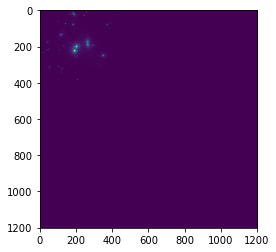

In [9]:
plt.imshow(np.arcsinh(trac_mod))
plt.show()

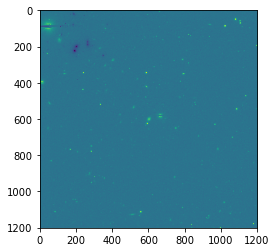

In [10]:
plt.imshow(np.arcsinh(img_data - trac_mod))
plt.show()

In [11]:
trac_obj.freezeParam('images')

In [12]:
trac_obj.optimize_loop()

{'steps': 1}

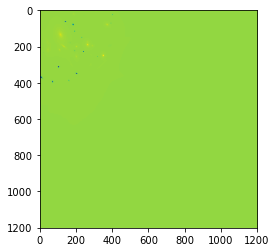

In [13]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(trac_mod_opt))
plt.show()

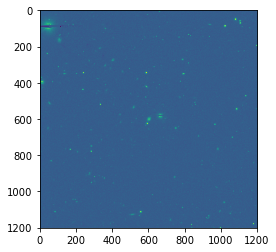

In [14]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(img_data - trac_mod_opt))
plt.show()

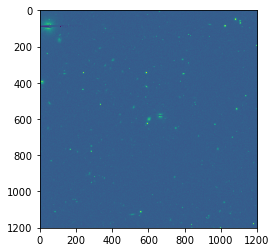

In [17]:
plt.imshow(np.arcsinh(img_data))
plt.show()
